# CLASIFICACION DE GENEROS MUSICALES COLOMBIANOS UTILIZANDO TECNICAS DE MACHINE LEARNING

* Sergio Steven Lopez Martinez
* Diego Cruz Moreno
* Jorge Camargo



### Installation of Requirements

In [ ]:
!pip install matplotlib
!pip install librosa
!pip install IPython
!pip install numpy

###Generic Imports

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import librosa as lb
import numpy as np
import sklearn
import os
from PIL import Image
import pathlib
import csv
import pylab as pl

###Unzip audio files (Vallenato)



In [ ]:
!wget -O vallenato.zip "https://drive.google.com/uc?export=download&id=1KFApZs0iauoKcngX9z5VgmA1frYH93ob"
!unzip vallenato.zip

In [ ]:
!ls -la vallenato

###Unzip audio files (Cumbia)

In [ ]:
!wget -O cumbia.zip "https://drive.google.com/uc?export=download&id=1MbTSu9qU8_gDP1zEDs8e4geypgpkwNVR"
!unzip cumbia.zip

In [ ]:
!ls -la cumbia

###Unzip audio files (Joropo)

In [ ]:
!wget -O joropo.zip "https://drive.google.com/uc?export=download&id=1UQ3U3oCqlHs9Hm3EaZgzAP9WkeApRe-O"
!unzip joropo.zip

###Unzip audio files (Carranga)

In [ ]:
!wget -O carranga.zip "https://drive.google.com/uc?export=download&id=1gBXiMnM2yO6NH5tVwQqDPvOCMx841LBP"
!unzip carranga.zip

###Unzip audio files (Bambuco)

In [ ]:
!wget -O bambuco.zip "https://drive.google.com/uc?export=download&id=1LTMHzubhdqOearTfJEt_FyScWapOuWJu"
!unzip bambuco.zip

###Unzip audio files (Pasillo)

In [ ]:
!wget -O pasillo.zip "https://drive.google.com/uc?export=download&id=1XBAtBPZLX0oEf7iCyNuPbPo5ZfmFFRrq"
!unzip pasillo.zip

###Loading audio files

In [ ]:
audio_path = 'pasillo/pasillo1.wav'

# Load the audio
x , sr = librosa.load(audio_path)

print(type(x), type(sr))

print(x.shape, sr)
# print(x)

<class 'numpy.ndarray'> <class 'int'>
(110250,) 22050


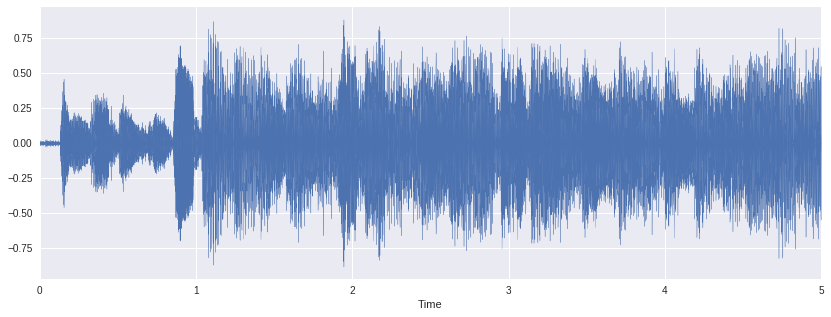

In [ ]:
# Save the numpy array in a txt file
np.savetxt("numpy_array.txt", x, fmt="%s")

# This returns an audio widget in the jupyter notebook
ipd.Audio(audio_path)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

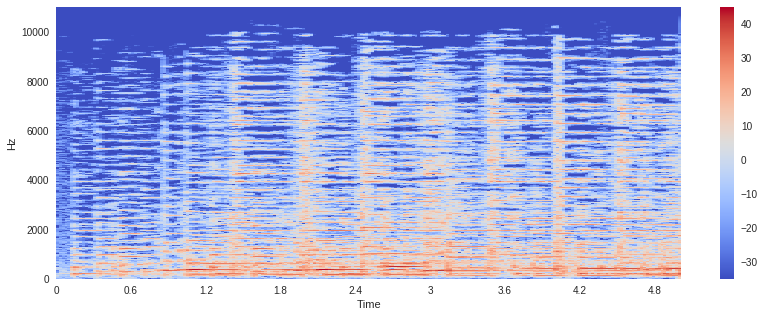

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

###Spectral centroids

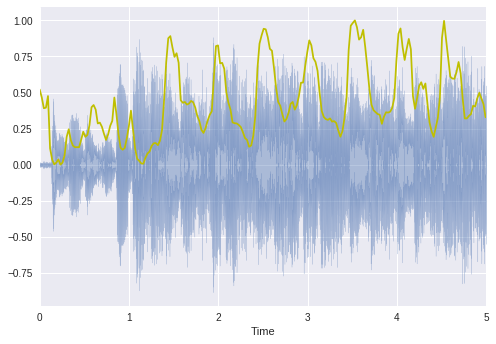

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)


def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='y')

###Spectral rolloff

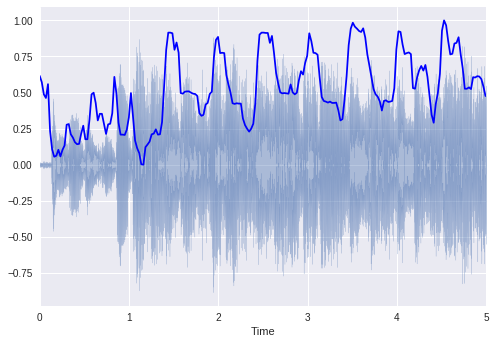

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='b')

### Chroma frequencies

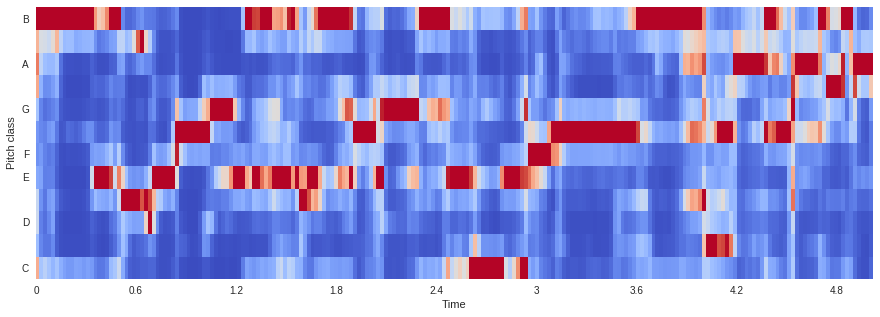

In [ ]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

In [ ]:
cmap = plt.get_cmap('magma')

plt.figure(figsize=(10,10))
genres = 'bambuco carranga cumbia joropo pasillo vallenato'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./{g}'):
        songname = f'./{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 720x720 with 0 Axes>

###Creacion de header con las caracteristicas a utilizar en la clasificación

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


###Creacion de el archivo .csv con los datos extraidos de las imagenes

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'bambuco carranga cumbia joropo pasillo vallenato'.split()
for g in genres:
    for filename in os.listdir(f'./{g}'):
        songname = f'./{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=15)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y, S=None, frame_length=2048, hop_length=512, center=True, pad_mode='reflect')
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [ ]:
!ls *

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
data = pd.read_csv('data.csv')
data.head()
#data.tail()
#data.all()
#data
#data[data.label == 'pasillo']

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,bambuco14.wav,0.323656,0.091994,2733.562387,2342.066783,5270.949300,0.177316,-164.128780,57.718116,-15.275544,...,3.332936,6.939993,-2.725621,-4.923783,0.335041,-7.257648,-7.926206,-11.429710,-0.200265,bambuco
1,bambuco11.wav,0.270753,0.172958,1480.809117,2033.688993,3178.988647,0.058053,-127.184821,126.712642,10.786049,...,-2.626101,-5.309386,6.668155,-5.874284,-14.464153,-15.747014,-5.439437,-7.277598,-2.360919,bambuco
2,bambuco2.wav,0.308493,0.164498,2296.489950,2556.621735,5493.159993,0.081159,-156.058646,47.111011,21.536563,...,6.764632,-2.217393,-5.129105,-5.475231,2.391442,-10.036511,-4.435582,-7.864283,-8.684095,bambuco
3,bambuco24.wav,0.265484,0.050667,2540.843216,2604.679814,5581.186930,0.126865,-211.438280,74.121560,10.682493,...,-9.127561,-12.265153,-6.149734,-11.887976,-2.956508,-14.869282,-3.481023,-14.137744,0.435579,bambuco
4,bambuco20.wav,0.230185,0.244249,1634.108530,1958.818970,3059.708659,0.071590,-95.138492,117.987503,-17.832510,...,-1.764189,-6.557010,2.786526,-4.925871,0.986573,-4.258801,0.089590,-3.024756,1.986125,bambuco


In [ ]:
data.shape

(180, 28)

In [ ]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

###Decodificamos las etiquetas

In [ ]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

###Escalamiento de las columnas de caracteristicas

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [ ]:
X.shape

(180, 26)

###Reduccion dimensionalidad (PCA)

In [ ]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=None)
sklearn_transf = sklearn_pca.fit_transform(X)
varianza_expl = sklearn_pca.explained_variance_ratio_
varianza_expl

array([1.93196784e-01, 1.32749110e-01, 1.02269764e-01, 8.41253841e-02,
       7.50710958e-02, 6.43410429e-02, 5.04199746e-02, 4.77752359e-02,
       3.40288945e-02, 3.17753948e-02, 2.72598430e-02, 2.53252092e-02,
       2.07798656e-02, 1.82293169e-02, 1.64267015e-02, 1.42816657e-02,
       1.22869973e-02, 1.06043873e-02, 9.81796360e-03, 9.15552241e-03,
       7.74679005e-03, 6.43908976e-03, 3.84654981e-03, 1.38584420e-03,
       5.11677538e-04, 1.49895666e-04])

In [ ]:
np.sum(varianza_expl[0:2]), np.sum(varianza_expl[0:7])

(0.3259458940447726, 0.7021731553149863)

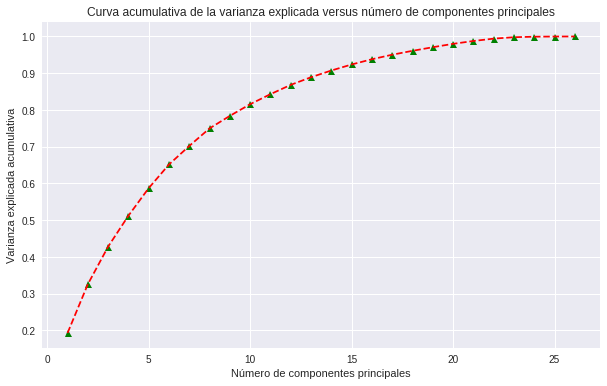

In [ ]:
cum_var_exp = np.cumsum(varianza_expl)
plt.figure(figsize = (10, 6))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulativa')
plt.title('Curva acumulativa de la varianza explicada versus número de componentes principales')
nc = np.arange(1, varianza_expl.shape[0] + 1)
plt.plot(nc, cum_var_exp, 'g^')
plt.plot(nc, cum_var_exp, '--r')
plt.show()

In [ ]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

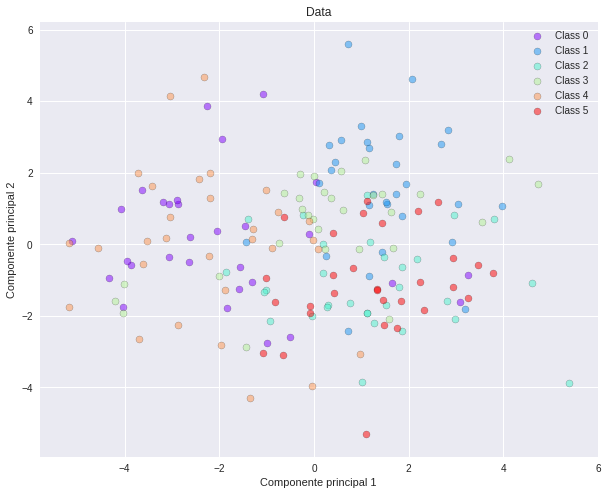

In [ ]:
from sklearn.model_selection import train_test_split

sklearn_pca = PCA(n_components=10)
sklearn_transf = sklearn_pca.fit_transform(X)
plt.figure(figsize = (10, 8))
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Vectores singulares más significativos después de la transformación lineal a través de PCA')
plot_data(sklearn_transf,y)

In [ ]:
## https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, metric='minkowski').fit_transform(X)
X_embedded.shape

(180, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

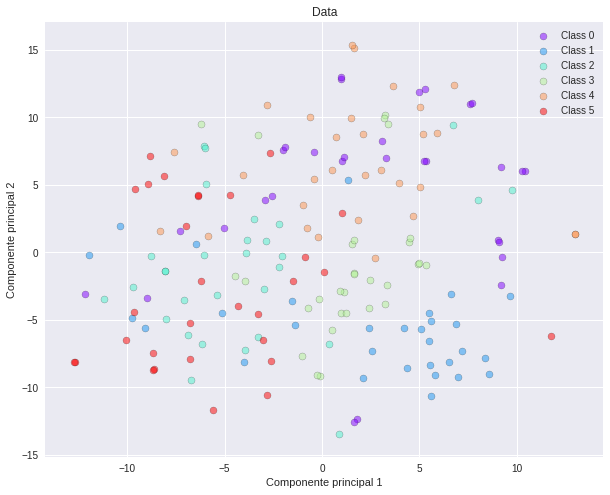

In [ ]:
plt.figure(figsize = (10, 8))
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Vectores singulares más significativos después de la transformación lineal a través de PCA')
plot_data(X_embedded,y)

###Dividing data into training and Testing set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( sklearn_transf, y, 
                                                             test_size=0.2, 
                                                             random_state=1234, 
                                                             stratify=y
                                                            )

partial_x_train, x_val, partial_y_train, y_val = train_test_split( X_train, y_train, 
                                                                                 test_size=0.25,
                                                                                 random_state=1234, 
                                                                                 stratify=y_train
                                                                                )

#Clasificacion Red Neuronal con Keras

In [ ]:
from keras import models
from keras import layers

In [ ]:
#(OCULTO)
##Crecion modelo de clasificacion por red nueronal

In [ ]:
results

[1.1093823115030925, 0.6111111111111112]

Predictions on Test Data

In [ ]:
predictions = model.predict(X_test)
print(predictions)

[[0.1573028  0.08832209 0.04764507 0.23158197 0.12363222 0.35151583]
 [0.0751976  0.22217439 0.07762874 0.36972946 0.13440901 0.12086081]
 [0.78641856 0.01784972 0.01032872 0.05139677 0.1279388  0.00606749]
 [0.05369855 0.11240882 0.04329409 0.6143827  0.15056255 0.02565332]
 [0.00490752 0.17790705 0.11819966 0.36337122 0.05773734 0.27787724]
 [0.29673013 0.05281536 0.07858798 0.10302861 0.39726365 0.0715742 ]
 [0.0074556  0.05007811 0.11473239 0.6984789  0.03688148 0.0923735 ]
 [0.0362708  0.5922464  0.04901823 0.23637699 0.05748971 0.02859783]
 [0.40935734 0.04551663 0.20418507 0.08249805 0.17193344 0.08650951]
 [0.1073095  0.15146428 0.09585914 0.48911887 0.12034278 0.03590539]
 [0.62516373 0.0053036  0.00169475 0.11603538 0.24874537 0.00305716]
 [0.05716259 0.2817964  0.2849941  0.17655072 0.0322976  0.1671986 ]
 [0.6182287  0.00631249 0.04199087 0.04343984 0.2831908  0.00683735]
 [0.01627529 0.51788104 0.03102016 0.42306477 0.00408548 0.00767327]
 [0.29536313 0.02866065 0.34967005

In [ ]:
predictions.argmax(axis=1)

array([5, 3, 0, 3, 3, 4, 3, 1, 0, 3, 0, 2, 0, 1, 2, 0, 3, 3, 0, 3, 4, 5,
       0, 3, 5, 0, 4, 4, 5, 5, 2, 5, 0, 2, 1, 4])

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Accuracy: {}'.format(test_acc))
print('Error: {}'.format(1-test_acc) + '\n')

print(f'Etiquetas: {genres}' + '\n')
print('Precision: {}'.format(metrics.precision_score(y_test, predictions.argmax(axis=1), average=None)))
print('Recall: {}'.format(metrics.recall_score(y_test, predictions.argmax(axis=1), average=None)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, predictions.argmax(axis=1), average=None))+ '\n')

36/36 [==============================] - 0s 348us/step
Accuracy: 0.6111111111111112
Error: 0.38888888888888884

Etiquetas: ['bambuco', 'carranga', 'cumbia', 'joropo', 'pasillo', 'vallenato']

Precision: [0.66666667 1.         0.75       0.44444444 0.6        0.5       ]
Recall: [1.         0.5        0.5        0.66666667 0.5        0.5       ]
F_1 score: [0.8        0.66666667 0.6        0.53333333 0.54545455 0.5       ]



###Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
mtrx1 = confusion_matrix(y_test, predictions.argmax(axis=1))
df2 = pd.DataFrame(mtrx1, index=genres, columns=genres)
print('Matriz de confusión')
print(df2)

Matriz de confusión
           bambuco  carranga  cumbia  joropo  pasillo  vallenato
bambuco          6         0       0       0        0          0
carranga         0         3       0       2        0          1
cumbia           0         0       3       1        0          2
joropo           0         0       0       4        2          0
pasillo          3         0       0       0        3          0
vallenato        0         0       1       2        0          3


#Clasificador RandomForest 

In [ ]:
ArrayRF = [2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_error = []
generalization_error = []

for nn in ArrayRF:
    knn = RandomForestClassifier(n_estimators=nn)
    knn.fit(partial_x_train, partial_y_train)
    train_error.append(1 - knn.score(partial_x_train, partial_y_train))
    generalization_error.append(1 - knn.score(x_val, y_val))

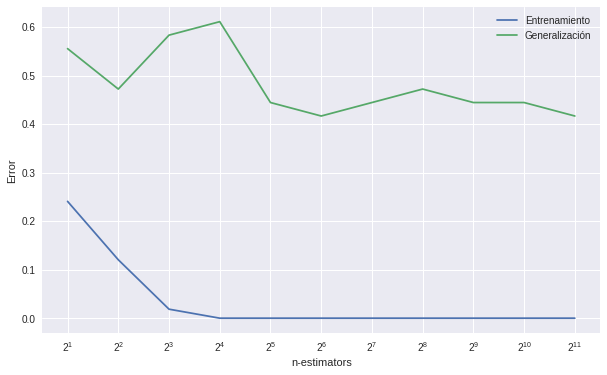

In [ ]:
pl.figure(figsize = (10, 6))

pl.plot(ArrayRF, train_error, label="Entrenamiento")
pl.plot(ArrayRF, generalization_error, label="Generalización")
pl.xscale("log", basex=2) 
pl.xticks(ArrayRF)
pl.xlabel("n-estimators")
pl.ylabel("Error")
# pl.gca().invert_xaxis()
# pl.arrow(13, 0.16, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
# pl.text(15, 0.165, 'Punto de balance')
pl.legend();

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

Random_forest = RandomForestClassifier(n_estimators=2**6)
Random_forest.fit(X_train, y_train)

print('Accuracy: {}'.format(Random_forest.score(X_test, y_test)))
print('Error: {}'.format(1 - Random_forest.score(X_test, y_test)) + '\n')

y_predic = np.array(Random_forest.predict(X_test))

print(f'Etiquetas: {genres}' + '\n')
print('Precision: {}'.format(metrics.precision_score(y_test, y_predic, average=None)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_predic, average=None)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, y_predic, average=None))+ '\n')

Accuracy: 0.6944444444444444
Error: 0.3055555555555556

Etiquetas: ['bambuco', 'carranga', 'cumbia', 'joropo', 'pasillo', 'vallenato']

Precision: [0.8        0.71428571 0.4        0.83333333 0.71428571 0.66666667]
Recall: [0.66666667 0.83333333 0.33333333 0.83333333 0.83333333 0.66666667]
F_1 score: [0.72727273 0.76923077 0.36363636 0.83333333 0.76923077 0.66666667]



###Matriz de confusión

In [ ]:
mtrx = confusion_matrix(y_test, y_predic)
df1 = pd.DataFrame(mtrx, index=genres, columns=genres)
print('Matriz de confusión')
print(df1)

Matriz de confusión
           bambuco  carranga  cumbia  joropo  pasillo  vallenato
bambuco          4         0       1       0        1          0
carranga         0         5       1       0        0          0
cumbia           0         1       2       1        0          2
joropo           0         0       0       5        1          0
pasillo          1         0       0       0        5          0
vallenato        0         1       1       0        0          4


#Clasificacion no supervisada por medio de clusters

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
#(OCULTO)
##Creacion modelo de clasificacion por clustering

##Clustering sin la aplicacion de PCA para reducir la *dimensionalidad*

##Inercia

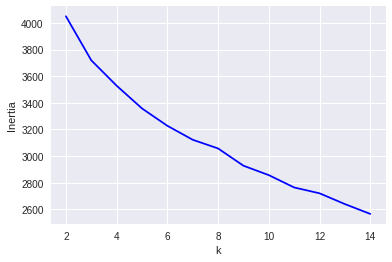

In [ ]:
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

##Coeficiente de silueta

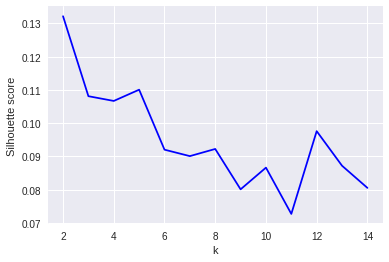

In [ ]:
silhouette_scores = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    y = km.predict(X)
    silhouette_scores.append(silhouette_score(X, y))
    
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()


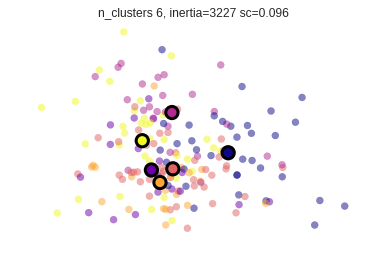

In [ ]:
plot_cluster_predictions(KMeans(), X, n_clusters = 6, show_metric=True)


##Clustering luego de reducir la dimensionalidad(PCA)

##Inercia

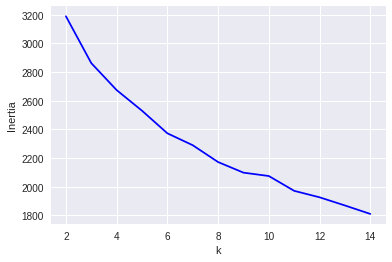

In [ ]:
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sklearn_transf)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

##Coeficiente de silueta

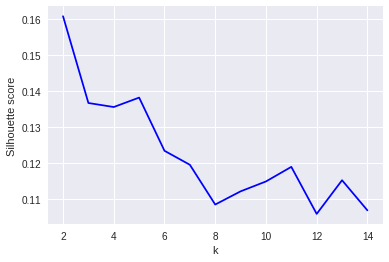

In [ ]:
silhouette_scores = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sklearn_transf)
    y = km.predict(sklearn_transf)
    silhouette_scores.append(silhouette_score(sklearn_transf, y))
    
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

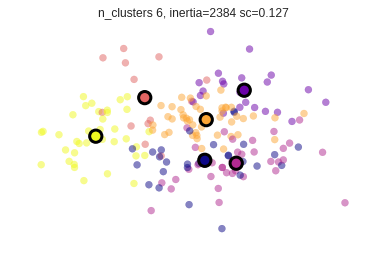

In [ ]:
plot_cluster_predictions(KMeans(), sklearn_transf, n_clusters = 6, show_metric=True)

##Clustering luego de T-SNE

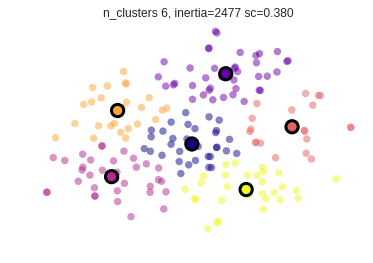

In [ ]:
plot_cluster_predictions(KMeans(), X_embedded, n_clusters = 6, show_metric=True)